In [71]:
import imutils
import numpy as np
import cv2
from PIL import Image
from IPython.display import display, Javascript
import time


In [73]:
timea = time.time()
timea

1666698475.3616548

# Face Segmentation

In [6]:
#!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt#
#!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [7]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [75]:
cap = cv2.VideoCapture(0)
time1 = time.time()
images_list = []

while True:
    success, img = cap.read()
    (h, w) = img.shape[:2]
    
        
    #image = imutils.resize((np.reshape(np.frombuffer(b64decode(frame_js["img"].split(',')[1])),np.uint8),(640,480)),width=400)
    #print(frame_js["img"].split(','))
    #print(len(image))
    #image = (np.frombuffer(b64decode(frame_js["img"].split(',')[1]),np.uint8))
    #print(len(image))
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
      # extract the confidence (i.e., probability) associated with the prediction
      confidence = detections[0, 0, i, 2]

      # filter out weak detections by ensuring the `confidence` is
      # greater than the minimum confidence threshold
      if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # draw the bounding box of the face along with the associated probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            img = img[startY:endY,startX:endX]
            if time.time() - time1 > 1:
                time1 = time.time()
                images_list.append(img)
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(img, text, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
            
    cv2.imshow('frame', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
print(len(images_list))

5


# Face Recognition

In [9]:
from deepface import DeepFace


In [56]:
DeepFace.stream(db_path="db")

Detector backend is  opencv
Emotion model loaded
Age model loaded
Gender model loaded
Facial attibute analysis models loaded in  0.00017213821411132812  seconds


Finding embeddings: 0it [00:00, ?it/s]

Embeddings found for given data set in  0.011384725570678711  seconds


1/1 [==============================] - 0s 241ms/step


## Face Recognition

[Tutorial](https://github.com/serengil/tensorflow-101/blob/master/python/vgg-face.ipynb)

In [38]:
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.utils import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [39]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [40]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [106]:
def preprocess_image(image):
    if image.shape[0] < 224:
        a = numpy.zeros(shape=(224,224,3))
        #TODO
        
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    print(img.shape)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    img = preprocess_input(img)
    print(img.shape)
    return img

In [88]:
img1_representation = vgg_face_descriptor.predict(preprocess_image('lucas.jpeg'))[0,:]
img2_representation = vgg_face_descriptor.predict(preprocess_image('leo.jpeg'))

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 286ms/step
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 295ms/step


In [66]:
img2_representation.shape

(1, 2622)

In [44]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [45]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)


In [108]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image((img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image((img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(load_img((img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(load_img((img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 285ms/step
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 273ms/step
Cosine similarity:  0.16946154832839966
Euclidean distance:  72.83404
verified... they are same person


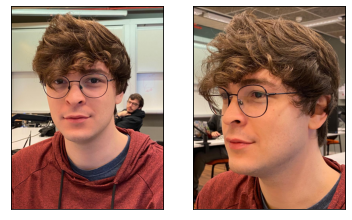

-----------------------------------------
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 278ms/step
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 293ms/step
Cosine similarity:  0.11794173717498779
Euclidean distance:  53.89962
verified... they are same person


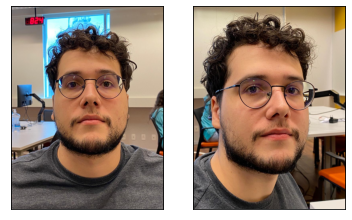

-----------------------------------------
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 299ms/step
(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 307ms/step
Cosine similarity:  0.4292125701904297
Euclidean distance:  101.14276
unverified! they are not same person!


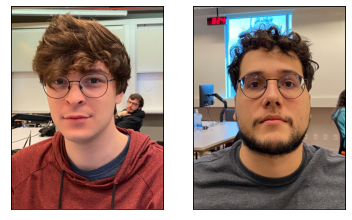

-----------------------------------------


In [109]:
verifyFace("leo.jpeg", "leo2.jpeg")
verifyFace("lucas.jpeg", "lucas2.jpeg")
verifyFace("leo.jpeg", "lucas.jpeg")

In [97]:
for face in images_list:
    for face2 in images_list:
        verifyFace(face, face2)

ValueError: in user code:

    File "/home/loe/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/loe/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/loe/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/loe/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/loe/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/loe/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 158, 3)
